## Terrain Classification using CNN

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
CHANNELS = 3
EPOCHS = 25
train_split = 0.8
train_size = 0.8
val_split = 0.1
test_split = 0.1

Loading data from local

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Terrain",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE    
)

Found 3196 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['Desert', 'Forest', 'Mountain', 'Plains']

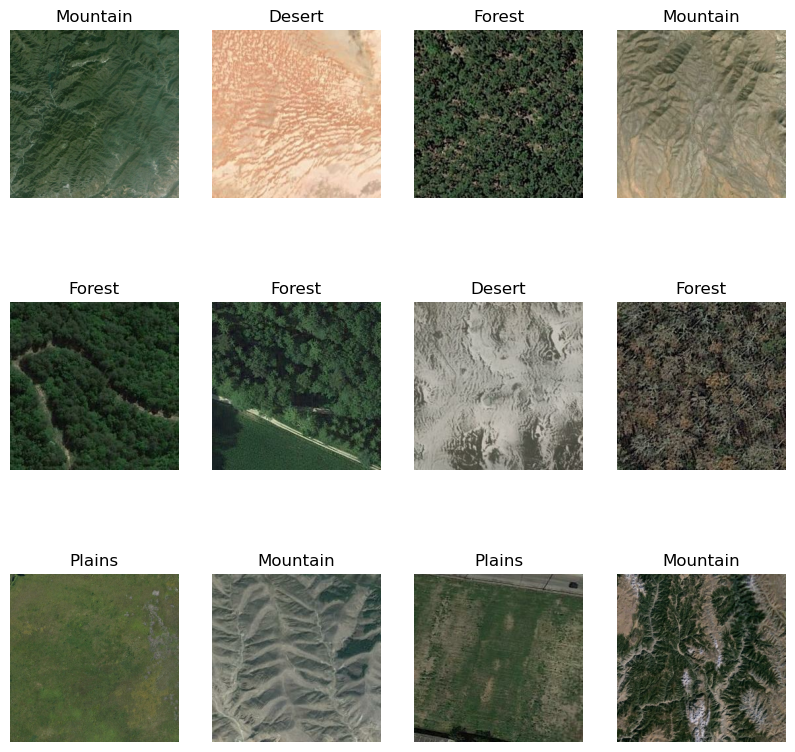

In [58]:
plt.figure(figsize = (10, 10))

for image_batch, label_batch in dataset.take(1):
    # print(image_batch.shape)
    # (16, 256, 256, 3)
    # Converts tensor into numpy
    # print(label_batch.numpy())
    # Display image in form of 3D array
    # print(image_batch[0].numpy())

    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [59]:
# Taking 80% data for training and remaining 20% for testing (splitting 10% each for validation and testing ) 

# len(dataset) 
# 200

# train_size = 0.8
# len(dataset)*train_size
# 160.0

# val_size = 0.1
# len(dataset)*val_size
# 20.0

In [5]:
# Taking first 160 inages for training from each class
training_ds = dataset.take(160)
len(training_ds)

160

In [6]:
# Taking images onwards of first 160 for testing d=from each class
testing_ds = dataset.skip(160)
len(testing_ds)

40

In [7]:
val_size = testing_ds.take(20)
len(val_size)

20

In [8]:
test_ds = testing_ds.skip(20)
len(test_ds)

20

Splitting data for different purposes

In [9]:
def get_data(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 1000):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    training_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)  
    
    return training_ds, test_ds, val_ds

In [10]:
training_ds, test_ds, val_ds = get_data(dataset)

In [11]:
len(training_ds)

160

Selecting data for training, validation and testing

In [12]:
training_ds = training_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

Input Pipeline

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255.0)    
])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)    
])

## Model of CNN layers for classification

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation, 
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation = 'softmax'),
    
])

model.build(input_shape = input_shape)

C:\Users\prati\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (16, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (16, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (16, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (16, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (16, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (16, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (16, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (16, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (16, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (16, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (16, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (16, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (16, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (16, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (16, 12544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (16, 64)               │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (16, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (16, 4)                │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,388 (3.42 MB)

 Trainable params: 896,388 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

history = model.fit(
    training_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=[reduce_lr]
)

Epoch 1/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 39s 207ms/step - accuracy: 0.4364 - loss: 1.1170 - val_accuracy: 0.5063 - val_loss: 0.9598 - learning_rate: 0.0010
Epoch 2/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 33s 209ms/step - accuracy: 0.6730 - loss: 0.7635 - val_accuracy: 0.7937 - val_loss: 0.6398 - learning_rate: 0.0010
Epoch 3/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 33s 208ms/step - accuracy: 0.7532 - loss: 0.6211 - val_accuracy: 0.7469 - val_loss: 0.6404 - learning_rate: 0.0010
Epoch 4/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 36s 223ms/step - accuracy: 0.8071 - loss: 0.5408 - val_accuracy: 0.8594 - val_loss: 0.3910 - learning_rate: 0.0010
Epoch 5/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 37s 229ms/step - accuracy: 0.8013 - loss: 0.5286 - val_accuracy: 0.6562 - val_loss: 0.5464 - learning_rate: 0.0010
Epoch 6/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 34s 215ms/step - accuracy: 0.7982 - loss: 0.5676 - val_accuracy: 0.8062 - val_loss: 0.4498 - learning_rate: 0.0010
Epoch 7/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 36s 227ms/step - accuracy: 0.8

In [19]:
scores = model.evaluate(test_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.8305 - loss: 0.5842


In [20]:
scores = model.evaluate(testing_ds)

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.8579 - loss: 0.5903


In [21]:
scores = model.evaluate(val_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.8803 - loss: 0.3709


In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

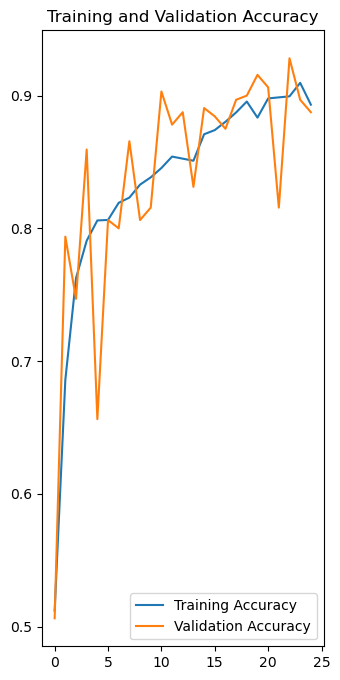

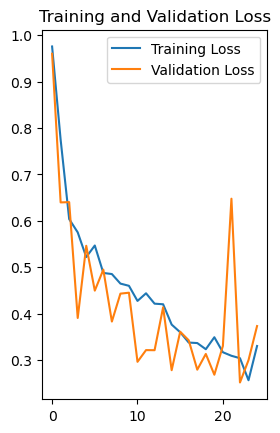

In [23]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")
plt.show()

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")
plt.show()

Predicting single image

First Image to Predict
First image's actual label:  Mountain
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Predicted label:  Mountain


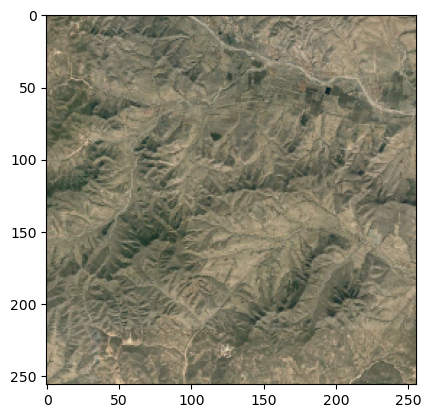

In [25]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0].numpy()
    
    print("First Image to Predict")
    plt.imshow(first_image)
    print("First image's actual label: ", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("Predicted label: ", class_names[np.argmax(batch_prediction[0])])

Predicting batch wise

In [26]:
def predict(model, img):
    img_array = tf.expand_dims(img, 0)  # Create a batch
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


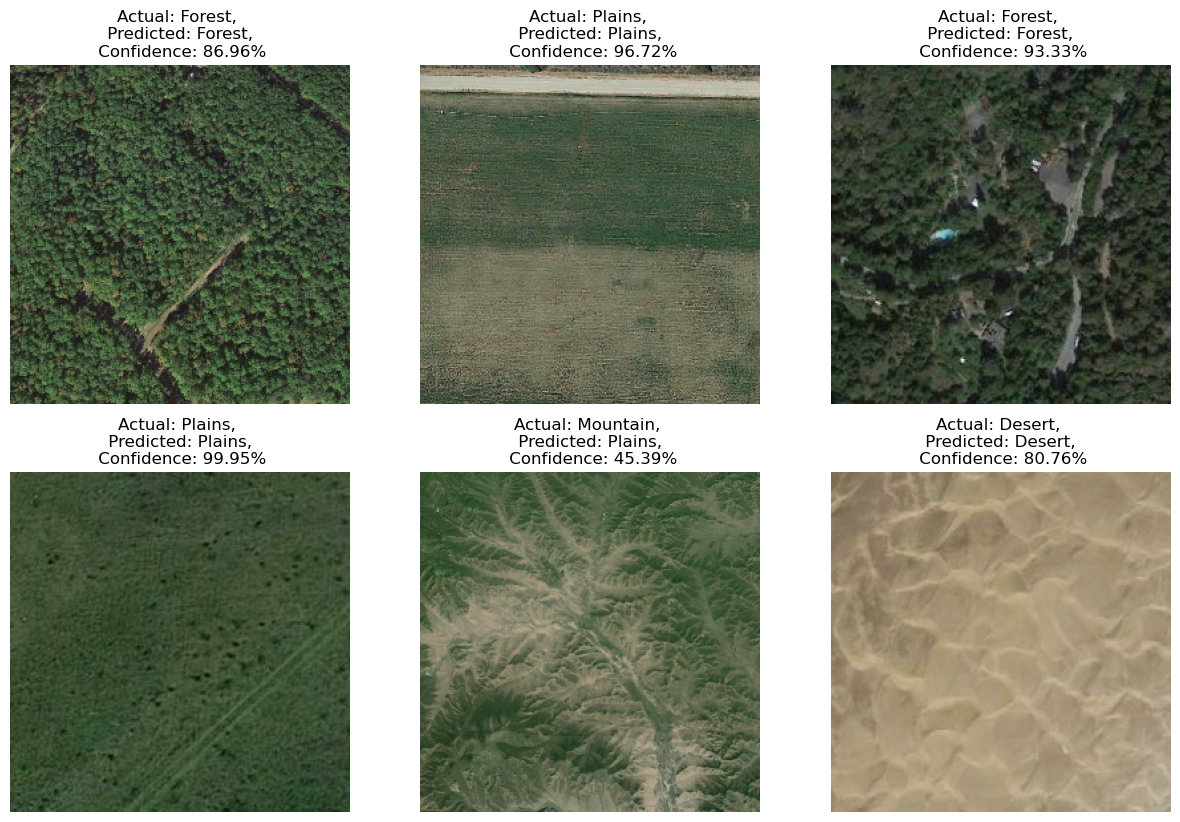

In [27]:
plt.figure(figsize = (15, 15))

for images, label in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[label[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis("off")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step
              precision    recall  f1-score   support

      Desert       0.24      0.23      0.24        78
      Forest       0.31      0.32      0.32        88
    Mountain       0.29      0.21      0.24        84
      Plains       0.27      0.36      0.31        70

    accuracy                           0.28       320
   macro avg       0.28      0.28      0.28       320
weighted avg       0.28      0.28      0.28       320



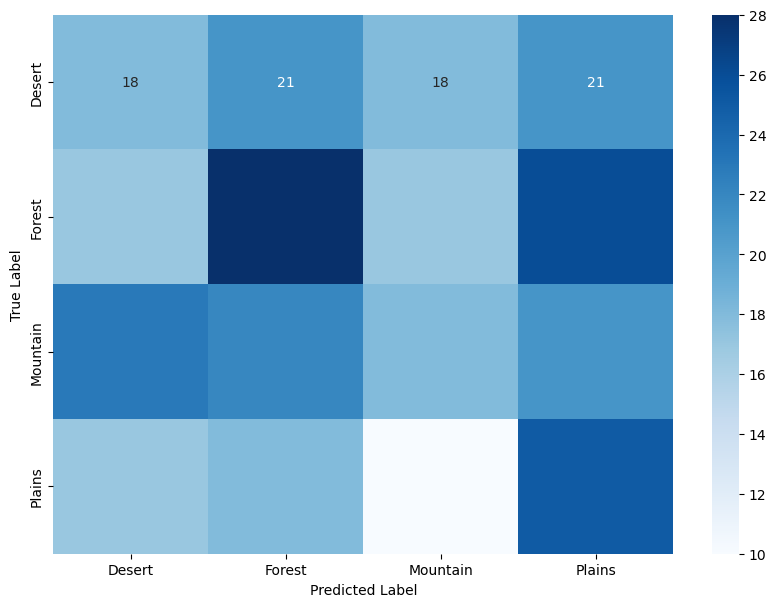

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `test_dataset` is your test data
# Get the true labels
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Get the predicted labels
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate precision, recall, f1-score
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Dataset distribution among all four classes

Training dataset class distribution: {'Desert': 657, 'Forest': 615, 'Mountain': 651, 'Plains': 633}
Validation dataset class distribution: {'Desert': 91, 'Forest': 73, 'Mountain': 82, 'Plains': 74}
Test dataset class distribution: {'Desert': 72, 'Forest': 69, 'Mountain': 86, 'Plains': 93}


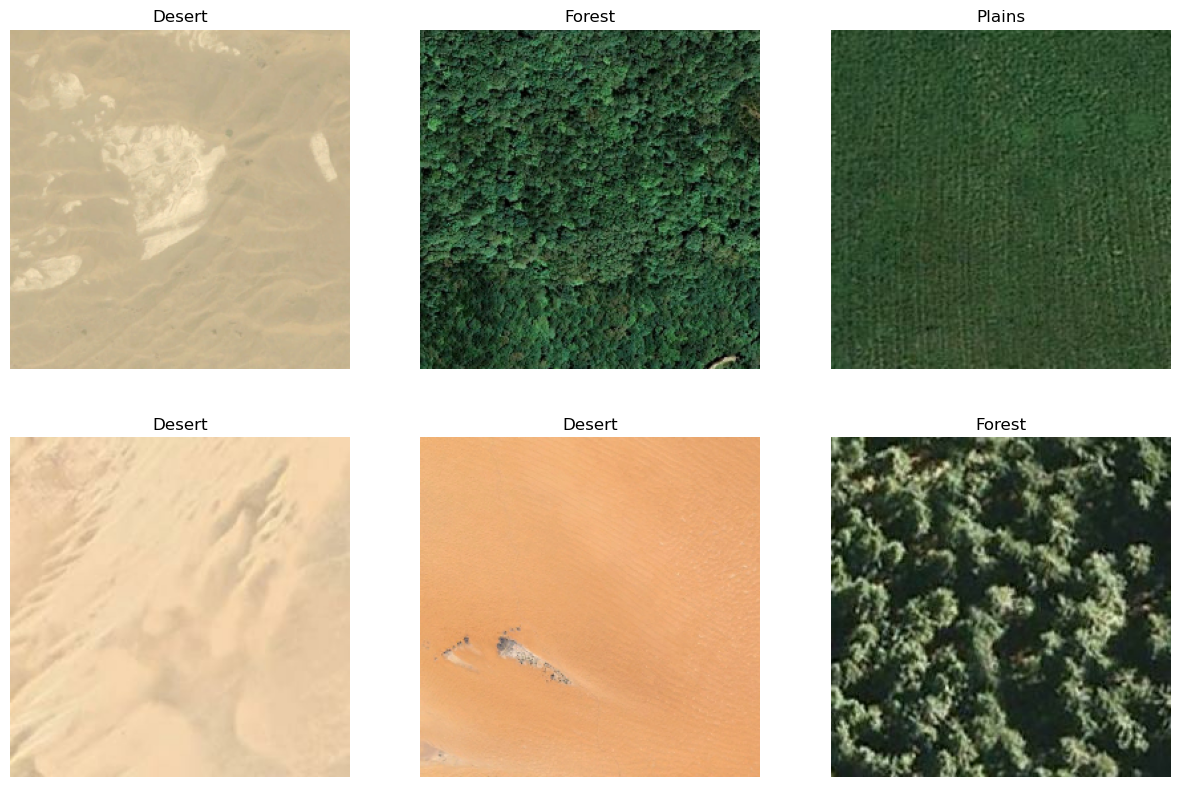

In [116]:
import tensorflow as tf

class_names = ['Desert', 'Forest', 'Mountain', 'Plains']

def check_dataset_balance(dataset):
    class_counts = {class_name: 0 for class_name in class_names}
    for images, labels in dataset:
        for label in labels:
            class_counts[class_names[label]] += 1
    return class_counts

training_class_counts = check_dataset_balance(training_ds)
val_class_counts = check_dataset_balance(val_ds)
test_class_counts = check_dataset_balance(test_ds)

print("Training dataset class distribution:", training_class_counts)
print("Validation dataset class distribution:", val_class_counts)
print("Test dataset class distribution:", test_class_counts)

plt.figure(figsize=(15, 15))
for images, labels in training_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

Count of images in training dataset from all four classes

In [108]:
import tensorflow as tf

class_counts = {}
for images, labels in training_ds:
    for label in labels:
        class_name = class_names[label]
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1

print(class_counts)

{'Mountain': 651, 'Desert': 657, 'Plains': 633, 'Forest': 615}


Accuracy calculation

In [29]:
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {100*final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {100*final_val_accuracy:.4f}")

Final Training Accuracy: 89.3192
Final Validation Accuracy: 88.7500


In [30]:
model.save(r"C:\Users\prati\Desktop\Python Analysis\models\terrain_one.keras")

By Prasad Namdev Kumbhar